In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
# The following directive activates inline plotting
%matplotlib inline

###### Select chromose to work with

In [3]:
chr_index = 1
chr = 'chr' + str(chr_index)

In [4]:
def plot_HiC(arr, figsize=(15,15)):
    '''
        Plot Hi-С map in blue-red colormap
        Function returns ax to add smth in the figure if needed
    '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    im = ax.matshow(arr, cmap='RdBu_r')
    fig.colorbar(im)
    return ax

###### Read loops coordinates, sizes and etc

In [5]:
loops_info = pandas.read_csv('GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt', sep='\t',
                             dtype = {'x1': np.long, 'x2': np.long, 'y1': np.long, 'y2': np.long})
loops = loops_info[loops_info.chr1 == str(chr_index)]

In [6]:
resolution = 10 ** 4

### Scaling

In [7]:
arr = np.load('arrs/10kb_' + str(chr_index) + 'chr_norm.npy')

In [8]:
def resize_image_arr(original_image, width, height):
    resize_image = np.zeros(shape=(width,height))
    for W in range(width):
        for H in range(height):
            new_width = int( W * original_image.shape[0] / width )
            new_height = int( H * original_image.shape[1] / height )
            resize_image[W][H] = original_image[new_width][new_height]
            
    return resize_image

In [9]:
def z_norm_zero_middle(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    z_normed_arr = (arr - mean)/std
    
    norm_arr = z_normed_arr - (np.max(z_normed_arr) + np.min(z_normed_arr))/2
    
    return norm_arr

In [10]:
loop_new_size = 100

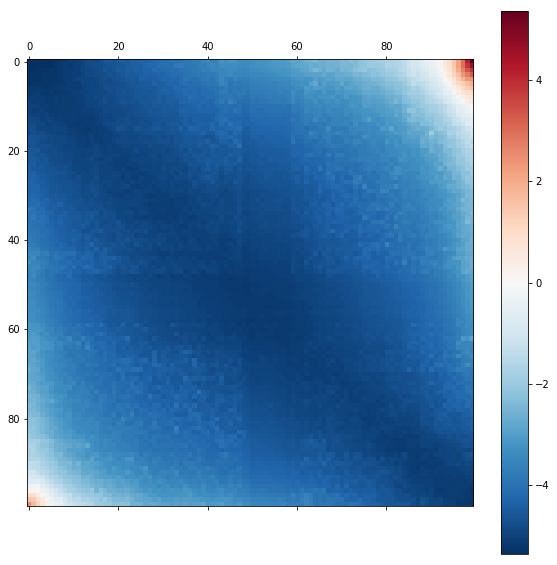

In [11]:
width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for index, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    window = 0
    
    original_image = arr[x1-window:y1+window, x2-window:y2+window]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    resize_image_sum = resize_image_sum + resize_image
    
plot_HiC(z_norm_zero_middle(resize_image_sum/loops.shape[0]), figsize=(10, 10))

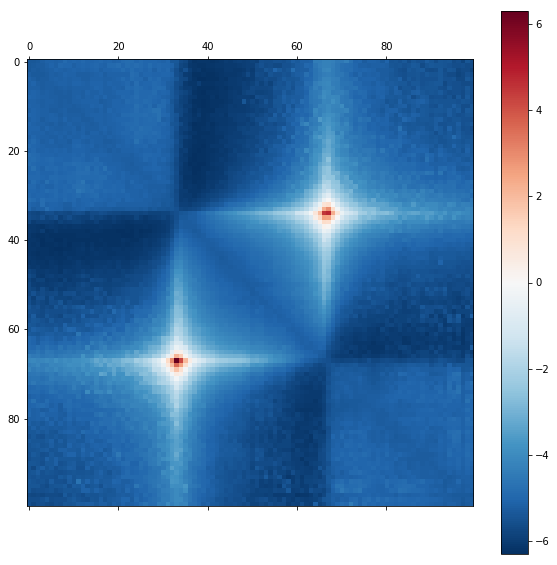

In [12]:
width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for index, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    window = y1-x1
    
    original_image = arr[x1-window:y1+window, x2-window:y2+window]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    resize_image_sum = resize_image_sum + resize_image
    
plot_HiC(z_norm_zero_middle(resize_image_sum/loops.shape[0]), figsize=(10, 10))

#### Calculate mean contact above the distance between bins

In [13]:
def calc_densities_mean(arr):
    '''
        calculate mean of each diagonal
        mean of each diagonal corresponds for the density for each genimic size step
    '''
    density = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        density[i] = np.nanmean(np.diagonal(arr, i))
        
    return density

In [14]:
def calc_densities_sum(arr):
    '''
        calculate mean of each diagonal
        sum of each diagonal corresponds for the density for each genimic size step
    '''
    density = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        density[i] = np.nansum(np.diagonal(arr, i))
        
    return density

In [15]:
def plot_densities(densities):
    fig = plt.figure()
    ax = plt.axes()

    for density in densities:
        plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
    plt.show()

###### raw data

In [16]:
arr = np.load('arrs/10kb_' + str(chr_index) + 'chr.npy')

#### loops

###### mean

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


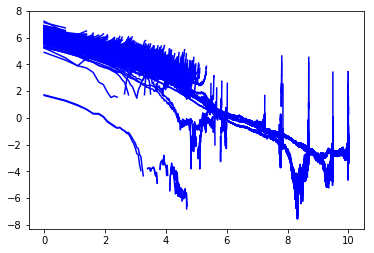

In [17]:
densities = []

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    loop = arr[x1:y1, x2:y2]
    loop[loop == -np.inf] = 0
    
    density = calc_densities_mean(loop)
    densities.append(density)
    
plot_densities(densities)

## Loops plus area after

In [18]:
loops_from = np.percentile((loops['y1']/resolution - loops['x1']/resolution), 20)

In [19]:
loops_to = np.percentile((loops['y1']/resolution - loops['x1']/resolution), 80)

In [20]:
l = loops[(loops['y1']/resolution - loops['x1']/resolution) > loops_from]
loops_d = l[(l['y1']/resolution - l['x1']/resolution) < loops_to]

_

In [21]:
max_loop_size = int(np.max(loops_d['y1']/resolution - loops_d['x1']/resolution))

In [22]:
def calc_densities_loop_plus_add_mean(row):
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    loop = arr[x1:y1, x2:y2]
    density = calc_densities_mean(loop)

    add = max_loop_size - (y1 - x1) + 10

    if x1-add > 0 and y1 + add < arr.shape[0]:
        after_loop = np.transpose(arr[y1:y1+add, x1-add:x1])
        after_density = np.flip(calc_densities_mean(after_loop))

        d = np.append(density, after_density)
    
        return d
    else:
        return None

single

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


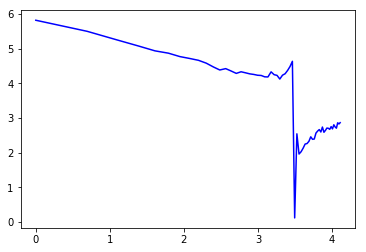

In [23]:
plot_densities([calc_densities_loop_plus_add_mean(loops_d.iloc[10])])

all

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


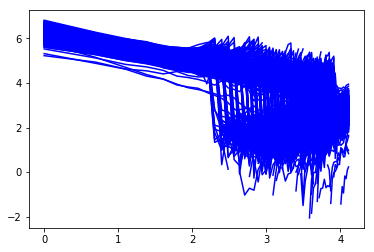

In [24]:
densities = []

for idx, row in loops_d.iterrows():
    density = calc_densities_loop_plus_add_mean(row)
    if density is not None:
            densities.append(density)
    
plot_densities(densities)

mean

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


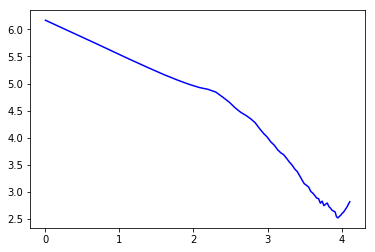

In [25]:
loop_densities_area_mean = np.nanmean(densities, axis=0)
plot_densities([loop_densities_area_mean])

###### sum

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


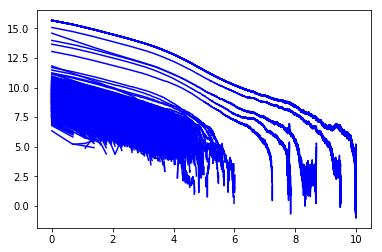

In [26]:
densities = []

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    loop = arr[x1:y1, x2:y2]
    loop[loop == -np.inf] = 0
    
    density = calc_densities_sum(loop)
    densities.append(density)
    
plot_densities(densities)

## between loops

###### mean

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


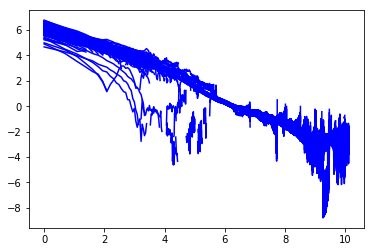

In [44]:
densities = []
        
begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if begin1 < x1 and begin2 < x2:
        a = arr[begin1:x1, begin2:x2]

        density = calc_densities_mean(a)
        densities.append(density)
        
    begin1 = y1
    begin2 = y2
        
plot_densities(densities)

## Plus area after

In [50]:
def calc_densities_btw_plus_add_mean(x1,x2,y1,y2):
    
    a = arr[x1:y1, x2:y2]
    density = calc_densities_mean(a)

    add = 200 - (y1 - x1)

    if x1-add > 0 and y1 + add < arr.shape[0]:
        after_a = np.transpose(arr[y1:y1+add, x1-add:x1])
        after_density = np.flip(calc_densities_mean(after_a))

        d = np.append(density, after_density)
    
        return d
    else:
        return None

In [52]:
begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if begin1 < x1 and begin2 < x2 and x1 - begin1 < 200:
        print(x1-begin1)
        
    begin1 = y1
    begin2 = y2

6
2
8
67
6
25
39
27
15
1
2
1
7
10
2
2
74
1
10
8
6
31
3
4
38
8
31
40
26
27
7
132
6
112
4
3
39
40
10
7
19
16
1
3
8
34
11
16
1
23
3
47
38
8
60
5
4
1
8
15
5
2
35
5
2
3
28
21
8
1
5
4
1
2
2
8
30
3
2
6
3
5
7
6
2
12
4
21
21
40
22
14
1
40
5
11
4
6
47
6
16
7
6
17
22
9
37
5
11
33
6
37
17
10
19
3
8
37
9
4
170
3
4
25
1
16
47
37
62
8
1
31
9
48
3
3
33
15
34
1
10
12
25
6
45
2
18
1
5
64
2
22
2
11
14
29
12
17
2
20
11
4
5
3
88
27
12
11
56
15
17
19
16
31
6
28
14
2
2
3
6
51
35
10
5
5
27
32
91
3
16
11
6
28
13
2
47
3
10
34
25
29
5
37
2
6
71
14
1
9
47
13
1
14
14
24
47
89
9
23
5
3
4
3
2
2
5
32
170
12
78
5
10
37
2
60
1
18
5
32
9
4
95
5
21
7
15
4
25
21
14
6


/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


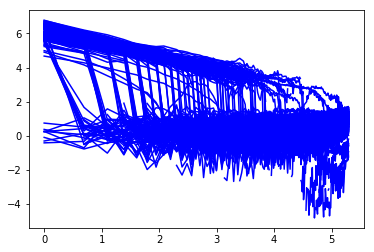

In [57]:
densities = []

begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if begin1 < x1 and begin2 < x2 and x1 - begin1 < 200:
        density = calc_densities_btw_plus_add_mean(begin1,begin2,x1,x2)
        if density is not None:
            densities.append(density)      
        
    begin1 = y1
    begin2 = y2
    
plot_densities(densities)

In [59]:
btw_densities_area_mean = np.nanmean(densities, axis=0)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


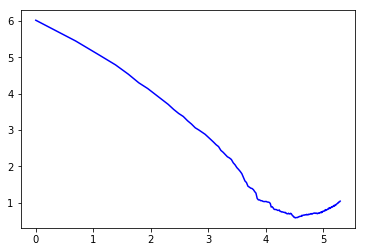

In [60]:
plot_densities([btw_densities_area_mean])

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


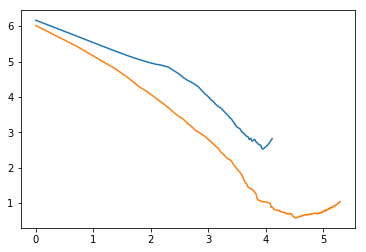

In [61]:
plt.plot(np.log(range(loop_densities_area_mean.shape[0])), np.log(loop_densities_area_mean), label='loop');
plt.plot(np.log(range(btw_densities_area_mean.shape[0])), np.log(btw_densities_area_mean), label='btw');

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


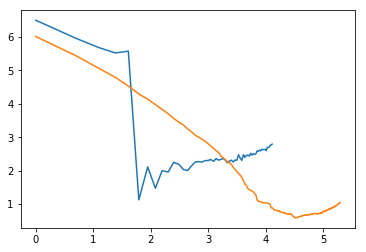

In [63]:
plt.plot(np.log(range(loop_densities_area_mean.shape[0])), np.log(calc_densities_loop_plus_add_mean(loops.iloc[10])), label='loop');
plt.plot(np.log(range(btw_densities_area_mean.shape[0])), np.log(btw_densities_area_mean), label='btw');

###### sum

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


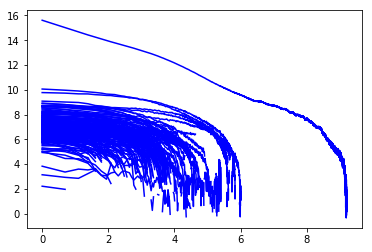

In [28]:
densities = []
        
x_begin = 0
y_begin = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:
        a = arr[x_begin:x1, y_begin:y1]
        a[a == -np.inf] = 0

        x_begin = x2
        y_begin = y2

        density = calc_densities_sum(a)
        densities.append(density)
        
plot_densities(densities)

### Scaling in one size

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


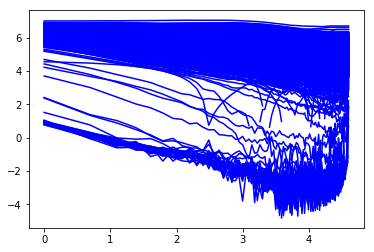

In [29]:
densities = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    original_image = arr[x1:y1, x2:y2]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    loop = resize_image
    
    density = calc_densities_mean(loop)
    densities.append(density)
    
plot_densities(densities)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


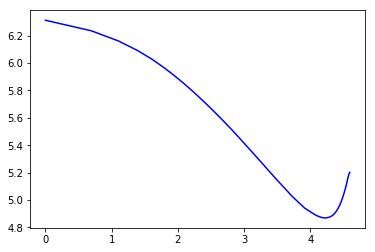

In [30]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/avg_density_loops_mean_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

In [31]:
densities = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    original_image = arr[x1:y1, x2:y2]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    loop = resize_image
    
    density = calc_densities_sum(loop)
    densities.append(density)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


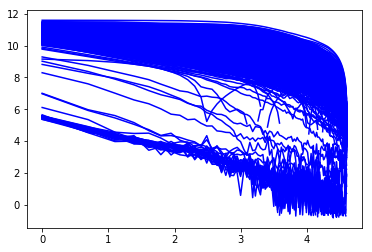

In [32]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


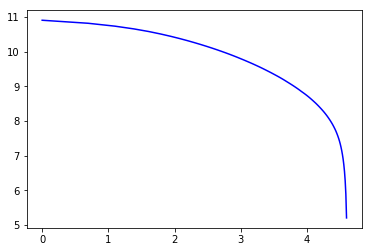

In [33]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/avg_density_loops_sum_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

### between loops

In [34]:
densities = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr[x_begin:x1, y_begin:y1]
        resize_image = resize_image_arr(original_image, width, height)
    
        resize_image[resize_image == -np.inf] = 0
        resize_image = np.nan_to_num(resize_image) 
    
        a = resize_image

        x_begin = x2
        y_begin = y2

        density = calc_densities_mean(a)
        densities.append(density)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


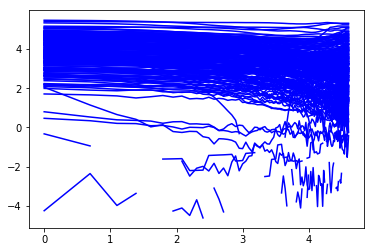

In [35]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


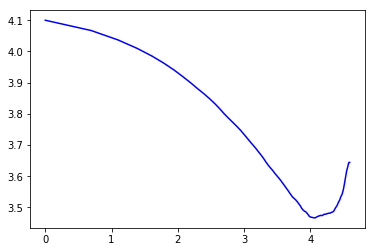

In [36]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/avg_density_btw_mean_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

In [37]:
densities = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr[x_begin:x1, y_begin:y1]
        resize_image = resize_image_arr(original_image, width, height)
    
        resize_image[resize_image == -np.inf] = 0
        resize_image = np.nan_to_num(resize_image) 
    
        a = resize_image

        x_begin = x2
        y_begin = y2

        density = calc_densities_sum(a)
        densities.append(density)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


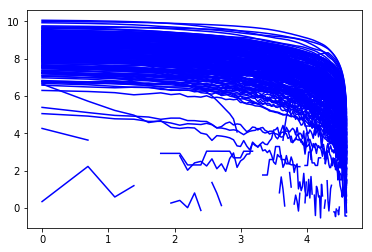

In [38]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


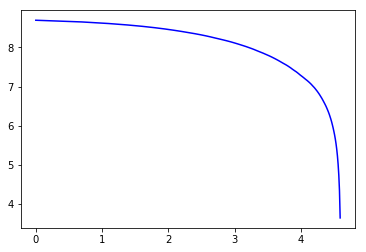

In [39]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/avg_density_btw_sum_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()